# Gesture Recognition Project

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- **Thumbs up**:  Increase the volume
- **Thumbs down**: Decrease the volume
- **Left swipe**: 'Jump' backwards 10 seconds
- **Right swipe**: 'Jump' forward 10 seconds  
- **Stop**: Pause the movie

## Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

## Objectives
**Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Import libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
# Set random seed to 30 to achieve same result in every run
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

In [4]:
train_df = pd.read_csv(os.path.join('./datasets/Project_data', 'train.csv'), delimiter=';', names=['video folder', 'class label', 'class'])
val_df   = pd.read_csv(os.path.join('./datasets/Project_data', 'val.csv'), delimiter=';', names=['video folder', 'class label', 'class'])
print('Total train samples :', len(train_df))
print('Total val samples   :', len(val_df))

Total train samples : 663
Total val samples   : 100


In [5]:
print(train_df.head(5))
print(val_df.head(5))

                               video folder     class label  class
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
                               video folder     class label  class
0  WIN_20180925_17_17_04_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_43_01_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_18_01_40_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_18_03_21_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180926_16_46_22_Pro_Left_Swipe_new  Left_Swipe_new      0


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def cropResize(image, y, z):
    h = image.shape[0]
    w = image.shape[1]
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [7]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [8]:
# getBatchDataAndBatchLabels skips `skipRecords` and takes next `batch_size` records

def getBatchDataAndBatchLabels(source_path, t, skipRecords, batch_size, video_frames, img_height, img_width):  
    #create a list of image numbers you want to use for a particular video
    img_idx = video_frames
    x = len(img_idx)
    y = img_height
    z = img_width
    
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    for folderIndex in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folderIndex + skipRecords].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folderIndex + skipRecords].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            resized_image = cropResize(image, y, z)
            
            batch_data[folderIndex,idx,:,:,0] = normalizeImage(resized_image[:,:,0]) #normalise and feed in the image
            batch_data[folderIndex,idx,:,:,1] = normalizeImage(resized_image[:,:,1]) #normalise and feed in the image
            batch_data[folderIndex,idx,:,:,2] = normalizeImage(resized_image[:,:,2]) #normalise and feed in the image
            
        batch_labels[folderIndex, int(t[folderIndex + skipRecords].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [9]:
def generator(source_path, folder_list, batch_size, video_frames, img_height, img_width):
    print('Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)
        totalFoldersCount = len(t)
        num_full_batches = totalFoldersCount//batch_size # calculate the number of full batches
        
        for currentBatchIndex in range(num_full_batches): # we iterate over the number of full batches
            # currentBatchNumber is 0 index basedso skipRecords value will be 0 for first batch,
            # 1 * 50 = 50 for second batch, 2 * 50 = 100 for third batch, and so on
            skipRecords = currentBatchIndex*batch_size
            yield getBatchDataAndBatchLabels(source_path, t, skipRecords, batch_size, video_frames, img_height, img_width)
    
        remainingItems = totalFoldersCount%batch_size
        if remainingItems != 0:
            # Control will reach here only of all full batches are processed
            # so take all remaining items in last batch
            # For last partial batch skipRecords will be fullbatches * batch size
            # e.g. 663 records have 13 full batches and 14th partial batch of size 13
            # skip 50 * 13 = 650, and take next 13
            skipRecords = num_full_batches * batch_size
            yield getBatchDataAndBatchLabels(source_path, t, skipRecords, remainingItems, video_frames, img_height, img_width)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = './datasets/Project_data/train'
val_path = './datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [12]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [13]:
def train_model(modelName, model, batch_size, video_frames, img_height, img_width, num_epochs):
    # Now that you have written the model, the next step is to compile the model.
    # When you print the summary of the model, you'll see the total number of parameters you have to train.
    
    optimiser = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.    
    train_generator = generator(train_path, train_doc, batch_size, video_frames, img_height, img_width)
    val_generator = generator(val_path, val_doc, batch_size, video_frames, img_height, img_width)
    
    # save model
    model_name = modelName + '_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]
    
    # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to 
    # decide the number of next() calls it need to make.
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    # Let us now fit the model. This will start training the model and with the help of the checkpoints,
    # you'll be able to save the model at the end of each epoch.
    
    fitted_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    return fitted_model

## Define Models

In [23]:
def getConv2DModel(img_idx, y, z):
    x = len(img_idx)
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation='relu'), input_shape=(x,y,z,3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same',activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(256))
    model.add(Dropout(0.25))
    
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(5,activation='softmax'))
    
    return model

In [15]:
def getConv3DModel_1(img_idx, y, z):
    x = len(img_idx)

    model = Sequential()
    
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(x,y,z,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2,2,2), padding='same'))
    model.add(Activation('relu'))    
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, (2,2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    return model

In [16]:
# Take below frames from each video of 30 frames
seq_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
image_height = 120
image_width = 120
batch_size = 50
num_epochs = 50

In [24]:
# Commenting Below, as this is not the final model
#conv2D_model = getConv2DModel(seq_idx, image_height, image_width)
#conv2D_fitted_model = train_model("Conv2D", conv2D_model, batch_size, seq_idx, image_height, image_width, num_epochs)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 60, 60, 32)   2080      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 60, 60, 32)  

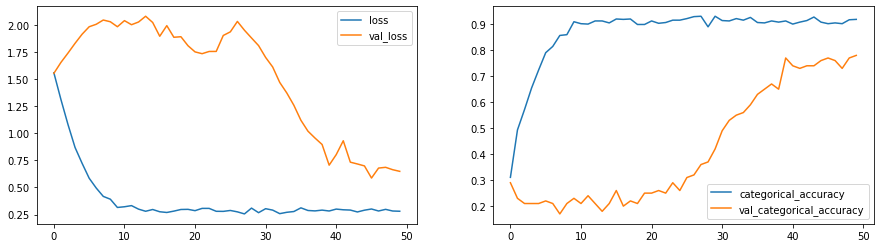

In [25]:
# Commenting Below, as this is not the final model
#plot(conv2D_fitted_model)

In [21]:
conv3D_model_1 = getConv3DModel_1(seq_idx, image_height, image_width)
conv3D_fitted_model_1 = train_model("Conv3D_1", conv3D_model_1, batch_size, seq_idx, image_height, image_width, num_epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_3 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 60, 60, 32)     4128      
                                                                 
 activation_4 (Activation)   (None, 7, 60, 60, 32)    

2022-11-15 17:02:48.725745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.3257 - categorical_accuracy: 0.4902Source path =  ./datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to Conv3D_1_init_2022-11-1516_59_51.635879/model-00001-1.32568-0.49020-1.64375-0.20000.h5
14/14 [==============================] - 77s 6s/step - loss: 1.3257 - categorical_accuracy: 0.4902 - val_loss: 1.6437 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.6588 - categorical_accuracy: 0.7496
Epoch 00002: saving model to Conv3D_1_init_2022-11-1516_59_51.635879/model-00002-0.65881-0.74962-2.82429-0.20000.h5
14/14 [==============================] - 77s 6s/step - loss: 0.6588 - categorical_accuracy: 0.7496 - val_loss: 2.8243 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.4507 - categorical_accuracy: 0.8401
Epoch 00003: saving model to Conv3D_1_init_2022-11-1516_59_51.635879

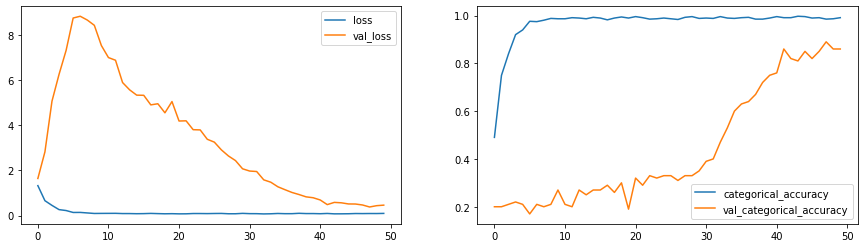

In [22]:
plot(conv3D_fitted_model_1)